#**Upravljanje multi-agentnim sustavima**

(verzija od 11.svi 2023.)

* Uvodimo kreativnije grafove
* Ovdje koristimo Schurovu dekompoziciju za ortogonalni komplement od jezgre od $L$
* Plotamo vrijednost $||F_i(s)||$
* Koristi se samo sustav dimenzije $n$ (dimenzija Laplaceove matrice grafa) 

#**Pitanje:**
* Treba li `get_Fi` vratiti vektor $F_i(s)$ ili normu $||F_i(s)||$?

* Kreacija grafa zna potrajati (ako se odabere veliki broj vrhova)

##**Raspisano**
Računamo vrijednost funkcije $F_i(s)$:
\begin{align*}
         F_i(s)  & = \frac{1}{is\alpha + \gamma}VV^T(L-\mu(s)I)^{-1}e_i \\
         & = \left[\: L = ZTZ^T \: \right]\\
         & = \frac{1}{is\alpha + \gamma}VV^TZ(T-\mu(s)I)^{-1}Z^*e_i  \\
         & = \left[ \: VV^TZ = VV^T[\:W \:\: V \:] = V \left[\:0 \: \: I\: \right]  \right] \\
         & = \frac{1}{is\alpha + \gamma}\left[\:0_{n×k} \:\: V \:\right](T-\mu(s)I)^{-1}Z^*e_i
\end{align*}

Za $L$ koristimo Schurovu dekompoziciju za $L= ZTZ^T$, $Z= [\: W\:\: V\:],$ $ \: W \in M_{n,k},$ $ \: V \in M_{n,n-k},$ gdje su V stupci od $Z$ koji pripadaju ne-nul elementima i dolazimo do oblika za $\Phi$ (jer vrijedi $L = L V V^T$):

$$\Phi(s) = \left(is \alpha + \gamma \right)\left(\frac{is\beta -s^2}{is \alpha + \gamma}I +L\right) = \\ =  (is \alpha + \gamma)\left(L - \mu(s)I\right),$$
gdje je $\mu(s) =\frac{is\beta -s^2}{is \alpha + \gamma} $.

Za vrijednost u $0$:
$$F_i(0) = \frac{1}{\gamma}V(V^TLV)^{-1}V^Te_i,$$ iskoristi se Schur za L i def za V pa se dobije
$$F_i(0) = \frac{1}{\gamma}VT_{22}^{-1}V^Te_i, $$
gdje je $$ T = 
\begin{bmatrix}
  T_{11} & T_{12}\\
  0 & T_{22}
  \end{bmatrix}.
$$ Pritom blok matrica $T_{11}$ na dijagonali ima $0$, a $T_{22}$ ima ne-nul svojstvene vrijednosti.




In [ ]:
import networkx as nx

import numpy as np
from scipy.sparse import csgraph
import scipy.signal as signal
import scipy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import time

###**`Laplace_inDegree`**
*   za graf G vraća Laplacian u željenoj formi.

In [ ]:
def _Laplace_inDegree(G):
  A = nx.adjacency_matrix(G)
  A = np.transpose(A)
  D = np.diag(A @ np.ones(np.size(A,1)).transpose())
  return D-A;

##**`mu_`**
* input: $\alpha, \beta, \gamma$
*output: funkcija ovisna o parametru $s$:  $$\mu(s)=\frac{is\beta -s^2}{is \alpha + \gamma} $$

In [ ]:
def mu_(alpha, beta, gamma):
    def mu(s):
        return (s*s-1j*s*beta)/(gamma + 1j*alpha*s);
    return mu;

###**`get_Fi`**
*   za graf $G$, parametre $\alpha, \beta, \gamma$, računa $Schurovu$ dekompoziciju inDegree Laplaceove matrice grafa, vraća ugnježdenu funkciju koja prima komponentu $i$ i dimenziju jezgre Laplaceove matrice grafa.

* pritom se kod računanja koristi `scipy.linalg.solve_triangular` koja poziva `LAPACK` rutinu za trokutasti linearni sustav jedndadžbi

Primjer poziva:

```
sys_f, Kernel_dim = get_Fi(G,alpha,beta,gamma)
Fi = sys_f(i)
print(Fi(5))
```




In [ ]:
def get_Fi(G,alpha,beta,gamma):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort=lambda x: abs(x)<1e-12)
    print("Računam Schurovu dekompoziciju")
    #print("Dimenzija jezgre: ",dim_Ker_L)
    V = Z[:,dim_Ker_L:]
    #VVZ = V@V.T@Z # ovo se pojednostavljuje u [0 V]
    VVZ = np.block([np.zeros((ndim,dim_Ker_L)),V])
    M = mu_(alpha,beta,gamma)
    EYE = np.diag(np.ones(ndim))
    def FF_(i):
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[:,i-1]
        def Fi(s):
            if (s == 0):
                ## Možda se može uštediti memorija i povećati brzina tako da
                # se ova matrica A definira u get_Fi pa ju se ovdje samo poziva
                # (ali koliko je to značajno kada je za s==0 tako i tako samo jedan poziv)
                A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(A,VTei)  #solve_triangular poziva LAPACK rutinu za trokutasti sustav
                F = V @ x /gamma
            else:
                ## Možda se može uštediti memorija i povećati brzina tako da
                # se ova matrica A definira u get_Fi pa joj se ovdje samo oduzimaju elementi na dijagonali
                A = T - EYE*M(s)
                x = la.solve_triangular(A,Z_Tei)
                F = VVZ @ x / ( alpha * s * 1j + gamma)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim;

In [ ]:
def get_Fi_norm(G,alpha,beta,gamma):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort=lambda x: abs(x)<1e-12)
    print("Računam Schurovu dekompoziciju")
    V = Z[:,dim_Ker_L:]
    #VVZ = V@V.T@Z # ovo se pojednostavljuje u [0 V]
    VVZ = np.block([np.zeros((ndim,dim_Ker_L)),V])
    M = mu_(alpha,beta,gamma)
    EYE = np.diag(np.ones(ndim))
    def FF_(i):
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[:,i-1]
        def Fi(s):
            if (s == 0):
                A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(A,VTei)  #solve_triangular poziva LAPACK rutinu za trokutasti sustav
                nrm =la.norm(V @ x /gamma)
                F = nrm
            else:
                A = T -EYE*M(s)
                x = la.solve_triangular(A,Z_Tei)
                nrm = la.norm(VVZ @ x)
                F = nrm/math.sqrt(s*s*alpha*alpha + gamma*gamma)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim;

#**Poziv nekog grafa G:**

[Dokumentacija](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.directed) za generatore grafova.

In [ ]:
A = nx.gnr_graph(150, 0.5)
B = nx.gnc_graph(20)
D = nx.gn_graph(150)
G = nx.gn_graph(200, kernel=lambda x: x ** 1.5)
C = nx.random_k_out_graph(70, 4, 50.0, self_loops=False, seed=None)


## Naći max od $H_\infty$: (npr. pomoću Nelder-Mead)

Računanje $max_{\omega \in \mathbb{R}} \overline{\sigma}(\hat{F}(j\omega))$

Računamo normu od:

$F_i(s) = VV^T \Phi(s)^{-1}e_i$

$F_i(0) = \frac{1}{\gamma}V (V^TLV)^{-1}V^Te_i$

$||F_i(s)||^2_\infty = sup_s||F_i(s)||^2_2 = sup_s ||VV^T \Phi(s)^{-1}e_i||^2_2$

In [ ]:
def obj_fun(s):
    return -la.norm(Fi(s))

Ovdje koristimo funkciju koja vraća vektor $F_i(s)$ pa je funkcija cilja u optimizaciju norma tog vektora.

In [ ]:
D = nx.gn_graph(60, kernel=lambda x: x ** 1.5)

In [ ]:
alpha=1
beta=1
gamma=1

x0 = 0.1
left_end = 0
right_end = 10000
spacing = 0.1
bounds = [(left_end,right_end)]
Graph = D
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
sys_f, Kernel_dim, ndim = get_Fi(Graph,alpha,beta,gamma)
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i)
    res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = la.norm(Fi(0))
    #print(res.x, norm, "0",norm_0)
    obj_values.append([la.norm(Fi(s)) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.008551836013793945
Trajanje  0 -te iteracije: 53.3272602558136
Trajanje  1 -te iteracije: 52.249993324279785
Trajanje  2 -te iteracije: 49.283897161483765
Trajanje  3 -te iteracije: 46.571388721466064
Trajanje  4 -te iteracije: 46.13645124435425
Trajanje  5 -te iteracije: 45.840999603271484
Trajanje  6 -te iteracije: 44.61211967468262
Trajanje  7 -te iteracije: 45.82007098197937
Trajanje  8 -te iteracije: 46.34148812294006
Trajanje  9 -te iteracije: 44.626760482788086
Trajanje  10 -te iteracije: 46.301061153411865
Trajanje  11 -te iteracije: 46.2623085975647
Trajanje  12 -te iteracije: 45.5679395198822
Trajanje  13 -te iteracije: 44.44328570365906
Trajanje  14 -te iteracije: 46.21360993385315
Trajanje  15 -te iteracije: 46.27017045021057
Trajanje  16 -te iteracije: 45.02545428276062
Trajanje  17 -te iteracije: 47.20569086074829
Trajanje  18 -te iteracije: 46.14812231063843
Trajanje  19 -te iteracije: 46.359976291656494
T

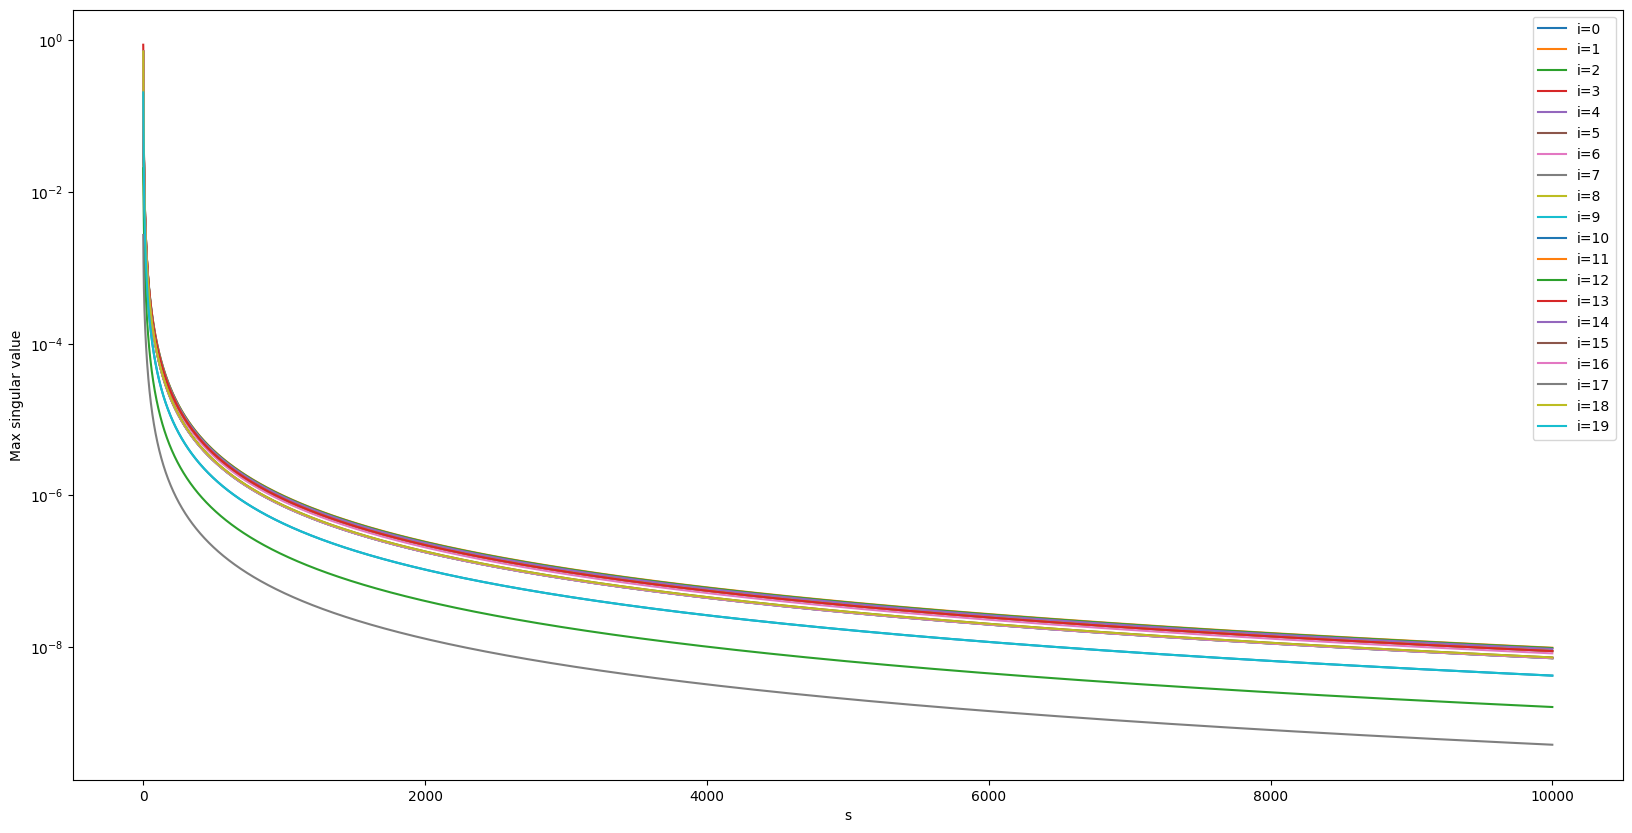

Dimenzija Laplaceove matrice:  20 
Dimenzija jezgre Laplaceove matrice:  9
Vrijeme izvršavanja:  0.3221101760864258 sec


In [ ]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range, obj, label = f"i={i}")
    i+=1;

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

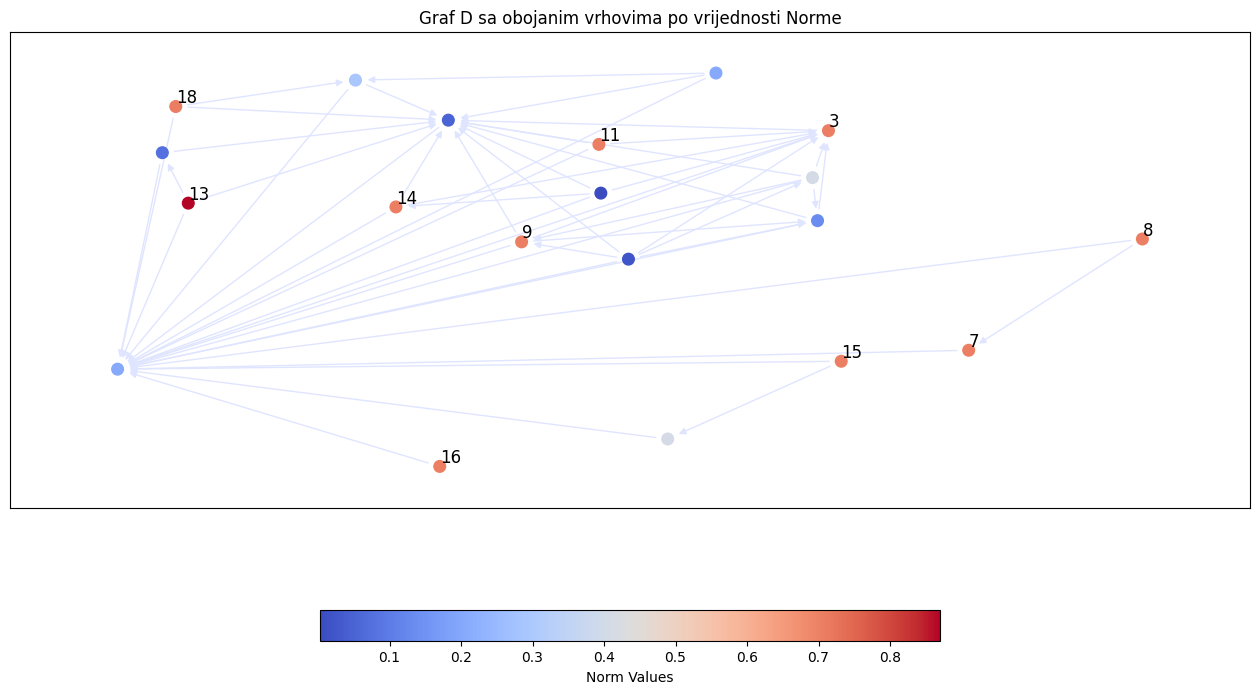

Dimenzija Laplaceove matrice:  20 
Dimenzija jezgre Laplaceove matrice:  9
Vrijeme izvršavanja:  0.3221101760864258 sec


In [ ]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Ovdje koristimo funkciju koja vraća normu vektora $||F_i(s)||$.

In [ ]:
def obj_fun_N(s):
    return -Fi(s)

alpha=1
beta=1
gamma=1

x0 = 0.1
left_end = 0
right_end = 100
spacing = 0.1
bounds = [(left_end,right_end)]
Graph = B
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
sys_f, Kernel_dim, ndim = get_Fi_norm(Graph,alpha,beta,gamma)
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i)
    Fi = sys_f(i)
    res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = Fi(0)
    #print(res.x, norm, "0",norm_0)
    #print(res.x, norm, "0",norm_0)
    obj_values.append([Fi(s) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.009032249450683594
Trajanje  0 -te iteracije: 0.2751636505126953
Trajanje  1 -te iteracije: 0.2850949764251709
Trajanje  2 -te iteracije: 0.283738374710083
Trajanje  3 -te iteracije: 0.31786656379699707
Trajanje  4 -te iteracije: 0.26538562774658203
Trajanje  5 -te iteracije: 0.27301788330078125
Trajanje  6 -te iteracije: 0.3376500606536865
Trajanje  7 -te iteracije: 0.2544541358947754
Trajanje  8 -te iteracije: 0.27542853355407715
Trajanje  9 -te iteracije: 0.26776790618896484
Trajanje  10 -te iteracije: 0.3208446502685547
Trajanje  11 -te iteracije: 0.24869561195373535
Trajanje  12 -te iteracije: 0.28294825553894043
Trajanje  13 -te iteracije: 0.28673362731933594
Trajanje  14 -te iteracije: 0.32903480529785156
Trajanje  15 -te iteracije: 0.2528359889984131
Trajanje  16 -te iteracije: 0.26851916313171387
Trajanje  17 -te iteracije: 0.34076476097106934
Trajanje  18 -te iteracije: 0.6616337299346924
Trajanje  19 -te itera

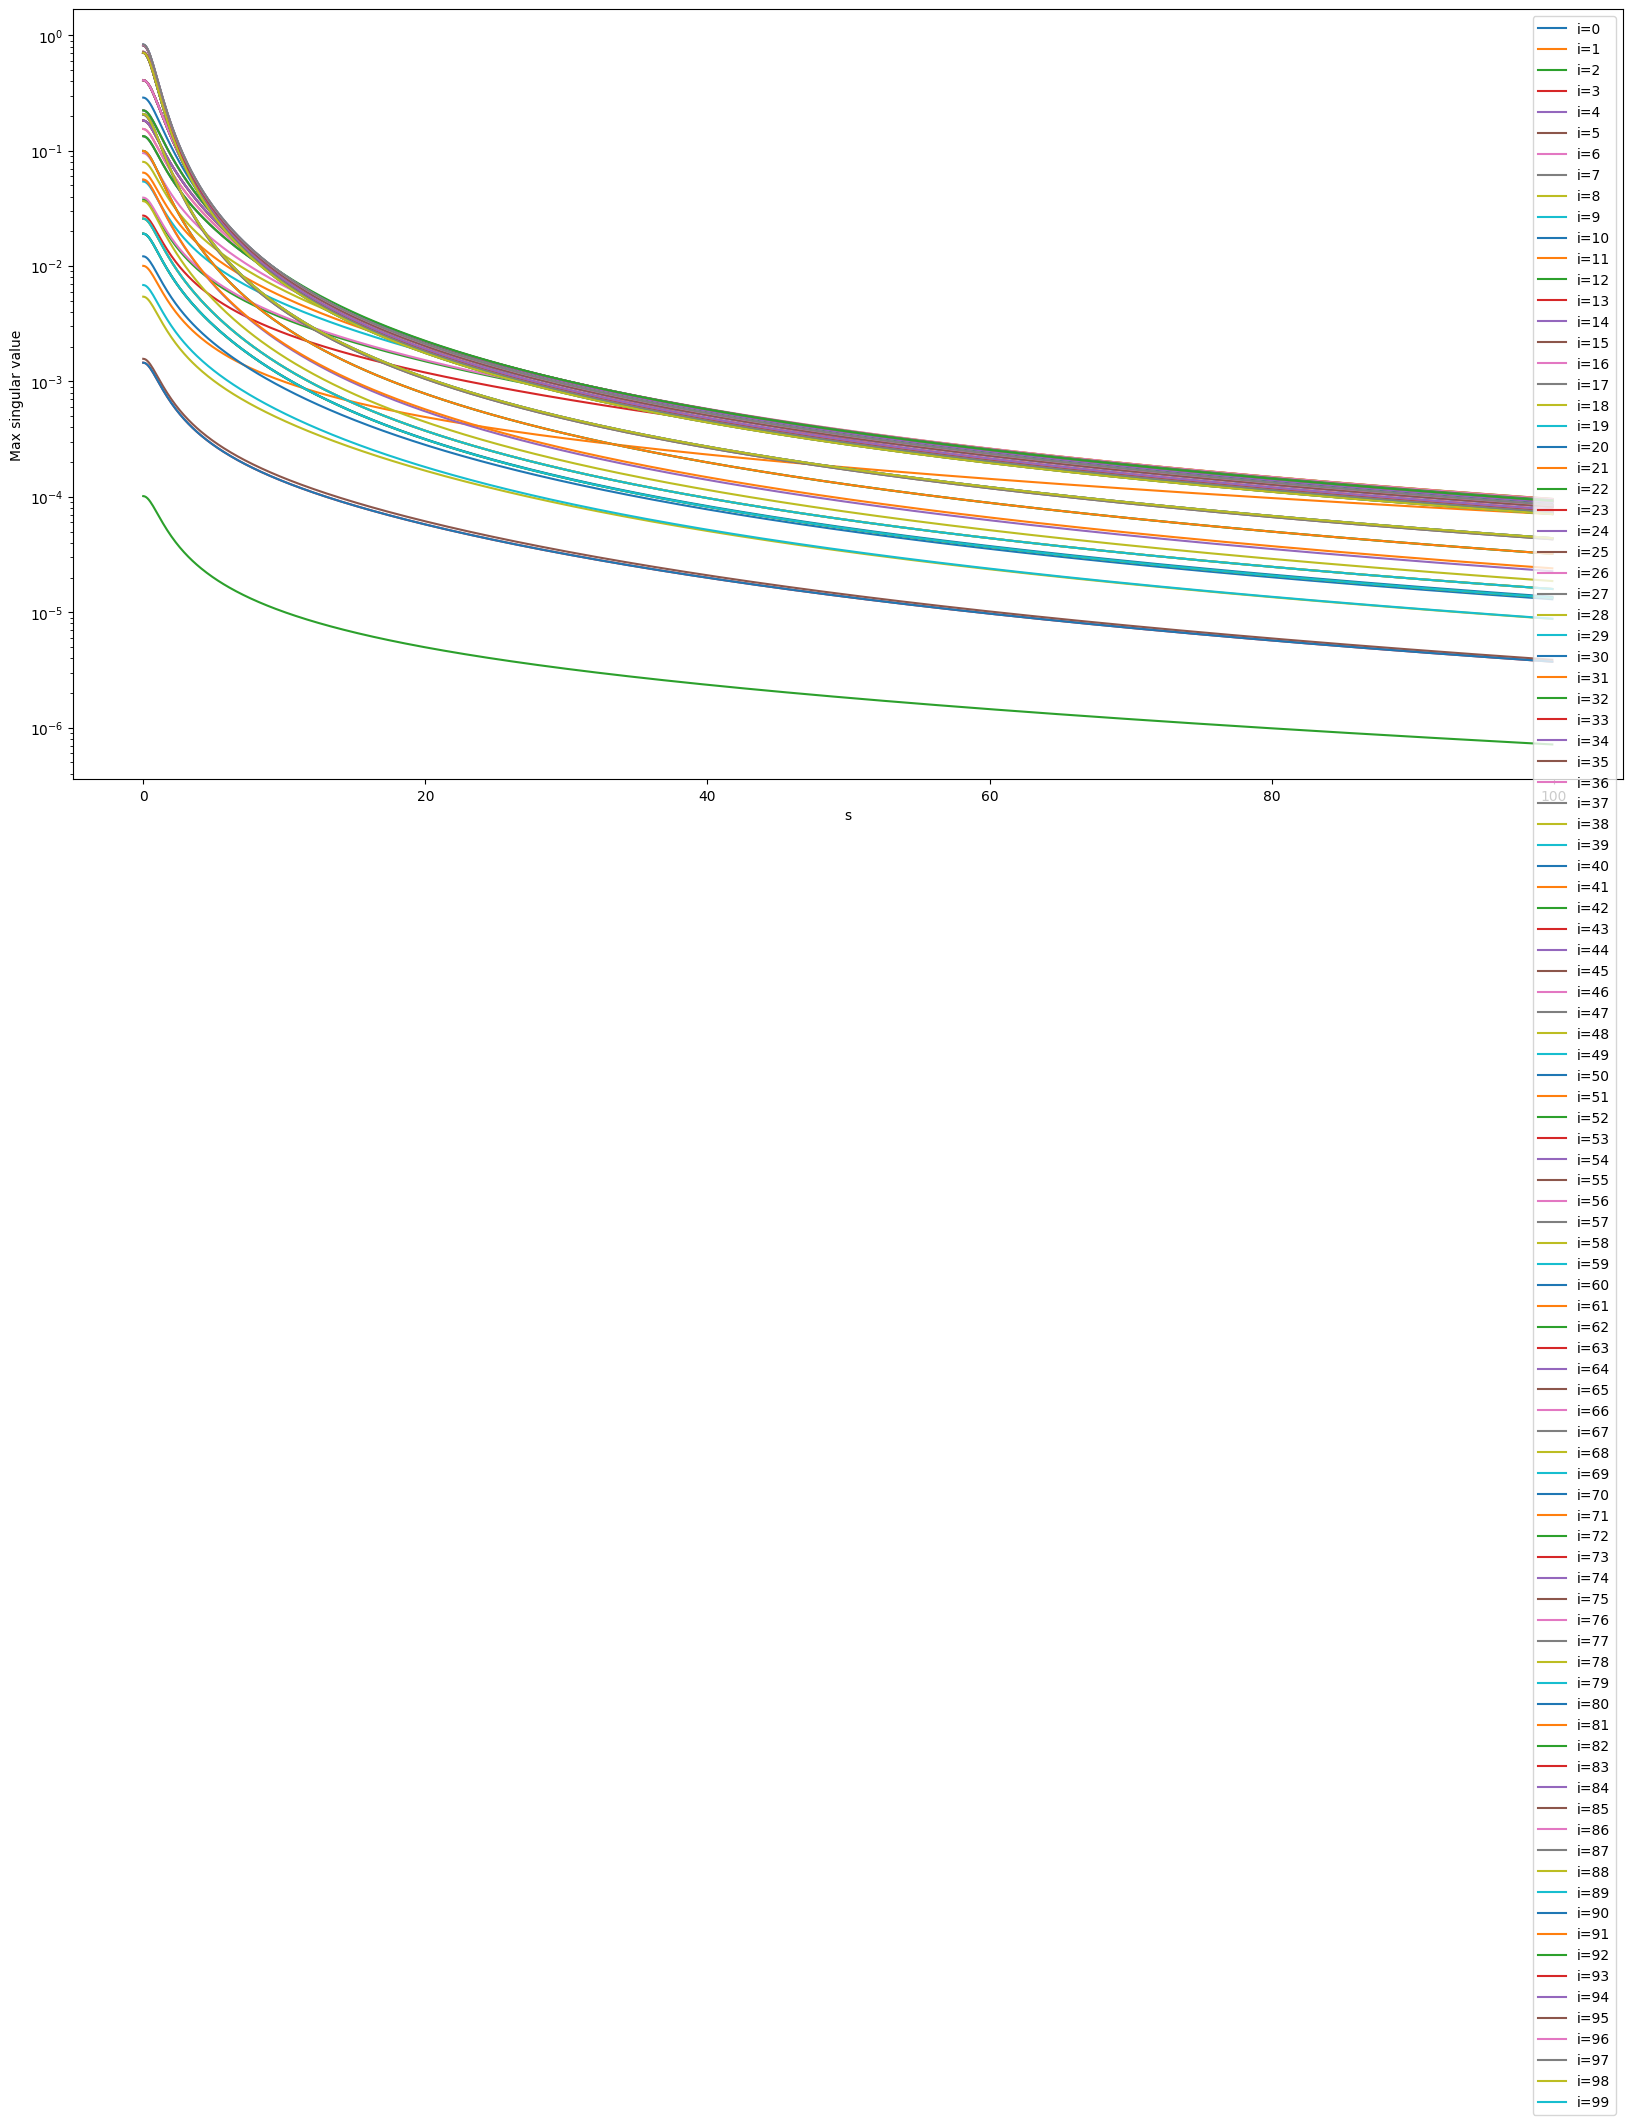

Dimenzija Laplaceove matrice:  100 
Dimenzija jezgre Laplaceove matrice:  47
Vrijeme izvršavanja:  0.11610817909240723 sec


In [ ]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range, obj, label = f"i={i}")
    i+=1;

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

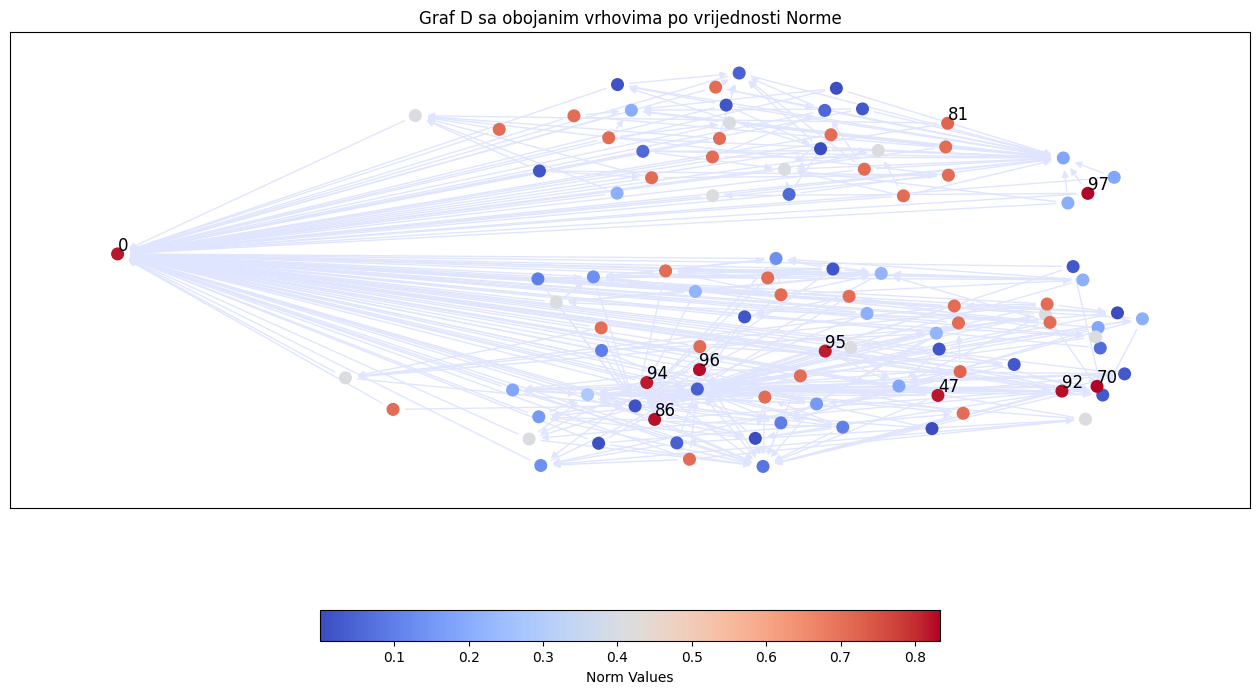

Dimenzija Laplaceove matrice:  100 
Dimenzija jezgre Laplaceove matrice:  47
Vrijeme izvršavanja:  0.11610817909240723 sec


In [ ]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")